##

## AMSC661, Homework 9
#### Dominic Flocco, April 12, 2023

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import math

plt.rcParams.update({'font.family': 'Times', 'text.usetex': True, 'font.size': 18})

In [2]:
# define the exact solution
def ExactSolution(x,y):
    # y^{2}*sin(pi*x)
    return y.pow(2) * torch.sin(np.pi*x)

In [3]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1])
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1)
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[0.0455, 0.0455],
        [0.0455, 0.0909],
        [0.0455, 0.1364],
        [0.0455, 0.1818],
        [0.0455, 0.2273],
        [0.0455, 0.2727],
        [0.0455, 0.3182],
        [0.0455, 0.3636],
        [0.0455, 0.4091],
        [0.0455, 0.4545],
        [0.0455, 0.5000],
        [0.0455, 0.5455],
        [0.0455, 0.5909],
        [0.0455, 0.6364],
        [0.0455, 0.6818],
        [0.0455, 0.7273],
        [0.0455, 0.7727],
        [0.0455, 0.8182],
        [0.0455, 0.8636],
        [0.0455, 0.9091],
        [0.0455, 0.9545],
        [0.0909, 0.0455],
        [0.0909, 0.0909],
        [0.0909, 0.1364],
        [0.0909, 0.1818],
        [0.0909, 0.2273],
        [0.0909, 0.2727],
        [0.0909, 0.3182],
        [0.0909, 0.3636],
        [0.0909, 0.4091],
        [0.0909, 0.4545],
        [0.0909, 0.5000],
        [0.0909, 0.5455],
        [0.0909, 0.5909],
        [0.0909, 0.6364],
        [0.0909, 0.6818],
        [0.0909, 0.7273],
        [0.0909, 0.7727],
        [0.0

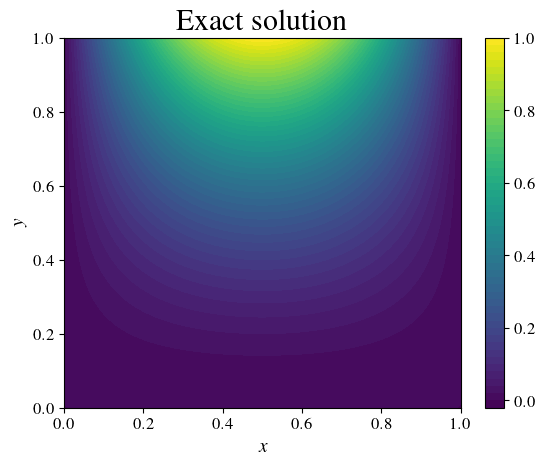

In [4]:
# define training points
npt1 = 23
strip_boundary = True
xtrain_grid, ytrain_grid, train_data = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
plt.contourf(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1), levels=50)  
#plt.scatter(train_data[:,0],train_data[:,1],s = 10, c = '#FF0000')
cbar = plt.colorbar(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.tick_params(labelsize=12)
plt.title("Computed Solution")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("$x$",fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.title("Exact solution")

train_data.requires_grad_(True)

In [5]:
class NN(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # 1st hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)
        
        
    def forward(self, xb):
        act = nn.Tanh()
        # act = torch.sigmoid()
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = torch.sigmoid(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out


def SolutionModel(x,y,model):
    # u(x,y) = B(x,y) + x(1-x)y[N(x,y;w) - N(x,1,w) - dN(x,1;w)/dy]
    # B(x,y) = 2*y*sin(pi*x)
    ones = torch.ones_like(y[:,None])
    ones.requires_grad_(True)
    # N(x,y; p)
    NN = model(torch.cat((x[:,None], y[:,None]), axis=1))[:,0]

    # N(x,1;p)
    NN1 = model(torch.cat((x[:,None], ones), axis = 1))[:,0]

    # dN(x,y;p)/dy at y =1
    NNy = torch.autograd.grad(outputs=NN1,
                            inputs=ones,
                            allow_unused=True,
                            grad_outputs=torch.ones_like(NN1),
                            retain_graph=True,
                            create_graph=True)[0][:, 0]
    C = x*(1-x)*y * (NN- NN1 - NNy)
    B = 2*y*torch.sin(np.pi*x)
    sol = B[:,None] + C[:,None]
    return sol

def Solution(x,y,model):
    # u(x,y) = B(x,y) + x(1-x)y[N(x,y;w) - N(x,1,w) - dN(x,1;w)/dy]
    # B(x,y) = 2*y*sin(pi*x)
    ones = torch.ones_like(y[:,None])
    ones.requires_grad_(True)
    # N(x,y; p)
    NN = model(torch.cat((x[:,None], y[:,None]), axis=1))[:,0]

    # N(x,1;p)
    NN1 = model(torch.cat((x[:,None], ones), axis = 1))[:,0]

    # dN(x,y;p)/dy at y =1
    NNy = torch.autograd.grad(outputs=NN1,
                            inputs=ones,
                            allow_unused=True,
                            grad_outputs=torch.ones_like(NN1),
                            retain_graph=True,
                            create_graph=True)[0][:, 0]
    C = x*(1-x)*y * (NN- NN1 - NNy)
    B = 2*y*torch.sin(np.pi*x)
    sol = B + C
    return sol

def RHS(x,y):
    return (2 - (np.pi**2)* y.pow(2))*torch.sin(np.pi*x)


In [6]:
N_neuron = 10
input_size = 2
output_size = 1

model = NN(input_size,N_neuron,output_size)

In [7]:
#prepare training data
size1,size2 = train_data.shape
rhs = torch.zeros(size1,)
train_ds = TensorDataset(train_data,rhs)

batch_size = 512
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)

loss at epoch 1 is 4.363064e+01
loss at epoch 101 is 3.282933e+00
loss at epoch 201 is 1.649934e-01
loss at epoch 301 is 1.322649e-01
loss at epoch 401 is 1.092805e-01
loss at epoch 501 is 9.044304e-02
loss at epoch 601 is 7.333115e-02
loss at epoch 701 is 5.786217e-02
loss at epoch 801 is 4.487543e-02
loss at epoch 901 is 3.466376e-02
loss at epoch 1001 is 2.717319e-02
loss at epoch 1101 is 2.200821e-02
loss at epoch 1201 is 1.854702e-02
loss at epoch 1301 is 1.618131e-02
loss at epoch 1401 is 1.449060e-02
loss at epoch 1501 is 1.322872e-02
loss at epoch 1601 is 1.224426e-02
loss at epoch 1701 is 1.144192e-02
loss at epoch 1801 is 1.076195e-02
loss at epoch 1901 is 1.016617e-02


Text(0.5, 0, 'Epoch')

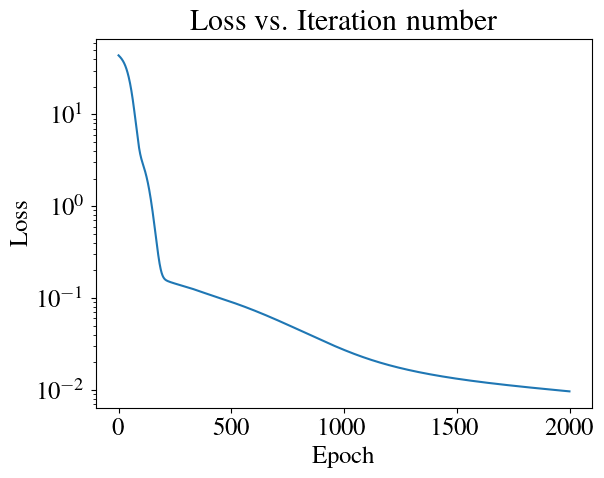

In [8]:
numIters = 2000
loss_vector = np.zeros(numIters)
for epoch in range(numIters):
    TOL = 1.0e-8
    for X,y in train_dl:
        optimizer.zero_grad()
        nn_approx = model(X)
        Q = SolutionModel(X[:,0],X[:,1],model)
        
        derivQ = torch.autograd.grad(Q,X,allow_unused=True, retain_graph=True, grad_outputs = torch.ones_like(Q), \
                                      create_graph=True)
        dQ = derivQ[0]
        
        deriv_xx_xy = torch.autograd.grad(dQ[:,0], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,0]), \
                                          retain_graph=True, create_graph=True)
        
        deriv_yx_yy = torch.autograd.grad(dQ[:,1], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,1]), \
                                          retain_graph=True, create_graph=True)
        
        Qyy = deriv_yx_yy[0][:,1]
        Qxx = deriv_xx_xy[0][:,0]
        
        lhs = Qxx+Qyy - RHS(X[:,0],X[:,1])

        loss = loss_fn(lhs,y)
        loss.backward()
        optimizer.step()
    loss_vector[epoch] = loss
    if epoch % 100 == 1:
        
        print('loss at epoch {} is {:.6e}'.format(epoch,loss))
    if loss < TOL:
        break
plt.figure()
plt.plot(torch.arange(numIters),loss_vector)
plt.title("Loss vs. Iteration number")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")

Max error = 4.781246e-03
Mean error = 9.367396e-04
RMS error = 1.337165e-03


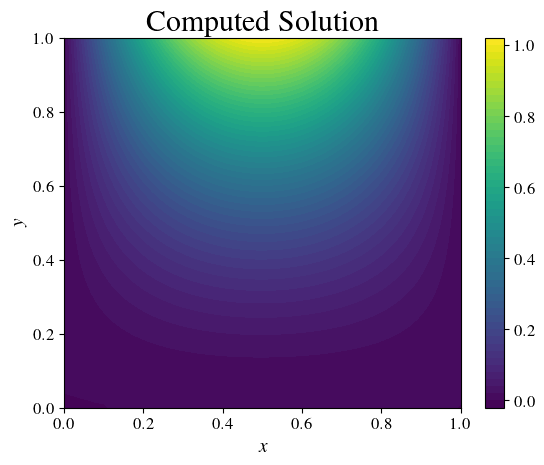

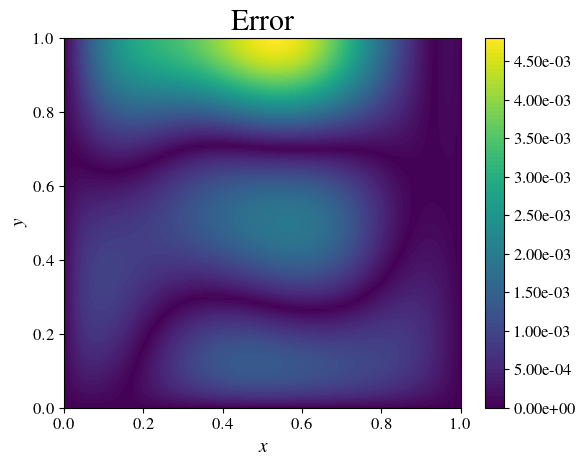

In [9]:
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)

sol_test = Solution(xytest[:,0], xytest[:,1], model)
sol_test = torch.reshape(sol_test, xtest_grid.shape)
plt.figure()
plt.contourf(xtest_grid,ytest_grid,sol_test.detach().numpy(),torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)), levels=50)   
cbar = plt.colorbar(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.tick_params(labelsize=12)
plt.title("Computed Solution")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("$x$",fontsize=14)
plt.ylabel("$y$", fontsize=14)
# compare with the exact solution
error = torch.abs(sol_test - sol_exact).detach().numpy()
error_vector = np.reshape(error,(Ntest,1))
error_max = np.max(error_vector)
plt.figure()
plt.contourf(xtest_grid,ytest_grid,error,np.arange(0.,error_max,error_max*0.1),levels=100)  
cbar2 = plt.colorbar(format="%1.2e")
cbar2.ax.tick_params(labelsize=12)
plt.title("Error")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("$x$",fontsize=14)
plt.ylabel("$y$", fontsize=14)
print("Max error = %1.6e" % np.max(error_vector))
print("Mean error = %1.6e" % np.mean(error_vector))
print("RMS error = %1.6e" % np.sqrt(np.mean(error_vector**2)))